In [26]:
"""
Description: Compare Yfinance and ECB data.
Author: Victor de Graaff & Jeroen van Dijk
Date: 28-10-2020
Maintainer: Victor de Graaff & Jeroen van Dijk
Email: victor.degraaff@d-data.nl & jeroen.vandijk@d-data.nl
Status: Dev
"""
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf

from currency_converter import CurrencyConverter
from datetime import timedelta, date, datetime

In [9]:
# Define currencies of interest
p13_currencies = ['USD','EUR','GBP',
                  'CHF','CNY','JPY',
                  'CAD','SEK','NOK',
                  'SGD','AUD','NZD',
                  'ZAR']

In [19]:
def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

def create_original_df(base_currency="EUR"):
    """Create the original dataframe based on ECB data.
   
    Parameters
    ----------
    base_currency : str
        The currency that is used to express other currency exchange rates."""
    c = CurrencyConverter("http://www.ecb.int/stats/eurofxref/eurofxref-hist.zip", 
                          fallback_on_wrong_date=True, 
                          fallback_on_missing_rate=True,
                          decimal=True)

    start_date = date(2000, 1, 1)
    end_date = date.today()

    date_list = []

    for single_date in daterange(start_date, end_date):

        cur_list = []
        cur_list.append(single_date)

        for currency in c.currencies:

            value = c.convert(1, base_currency, currency, date=single_date)
            cur_list.append(float(value))

        date_list.append(cur_list)

    columns_list = ["date"] + list(c.currencies)

    df = pd.DataFrame(date_list, columns=columns_list)
    df = df.sort_values(by="date", ascending=False)
    
    df["date"] = df["date"].map(lambda x: datetime(x.year, x.month, x.day, 0, 0))
    
    return df.sort_values("date").set_index("date")

In [20]:
# Create dataframe with pre-defined base currency
df = create_original_df("EUR")

# Determine splits for dev- (train and test) and validation set
train_start = date(2005, 4, 1)
test_start = date(2012, 1, 1)
validation_start = date(2015, 1, 1)
validation_end = date(2020, 10, 1)

# Create dev (train and test) and validation set
train = df.query("date >= @train_start and date < @test_start")
test = df.query("date >= @test_start and date < @validation_start")
dev = pd.concat([train, test])
val = df.query("date >= @validation_start and date < @validation_end")

In [10]:
# Function to retrieve historical currency data from yfinance
def download_currency_data(currency, base_currency="USD"):
    """Download currency data for pre-specified currency by using yfinance.
   
    Parameters
    ----------
    currency : str
        The currency of interest."""
    result = (yf.download(f"{base_currency}{currency}=X", start="2005-04-01", end="2014-12-31")[["Open"]]
                .reset_index()
                .rename(columns={"Open": currency, 
                                 "Date": "date"}))
                
    result["date"] = list(map(lambda x: datetime(x.year, x.month, x.day), list(result["date"])))
    
    return result.set_index("date")

In [13]:
# Download Yfinance data
yfinance_data = pd.concat([download_currency_data(currency, "EUR") for currency in p13_currencies if currency != "EUR"], axis=1)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [21]:
# Close
(np.abs(dev - yfinance_data).max() / (dev).mean()).sum()

0.72498209607763

In [22]:
# Open
np.abs(dev - yfinance_data).max() / (dev).mean()

AUD    0.079432
BGN         NaN
BRL         NaN
CAD    0.026449
CHF    0.070209
CNY    0.087505
CYP         NaN
CZK         NaN
DKK         NaN
EEK         NaN
EUR         NaN
GBP    0.031421
HKD         NaN
HRK         NaN
HUF         NaN
IDR         NaN
ILS         NaN
INR         NaN
ISK         NaN
JPY    0.066263
KRW         NaN
LTL         NaN
LVL         NaN
MTL         NaN
MXN         NaN
MYR         NaN
NOK    0.051434
NZD    0.059791
PHP         NaN
PLN         NaN
ROL         NaN
RON         NaN
RUB         NaN
SEK    0.020694
SGD    0.020625
SIT         NaN
SKK         NaN
THB         NaN
TRL         NaN
TRY         NaN
USD    0.152556
ZAR    0.058604
dtype: float64

In [23]:
# Check biggest largest errors of currency of interest
currency = "CNY"
np.abs(dev - yfinance_data).sort_values(currency, ascending=False)[currency]

date
2011-07-18    0.8087
2006-07-27    0.5074
2006-11-23    0.4996
2006-11-24    0.4810
2006-07-31    0.4748
               ...  
2014-12-14       NaN
2014-12-20       NaN
2014-12-21       NaN
2014-12-27       NaN
2014-12-28       NaN
Name: CNY, Length: 3562, dtype: float64

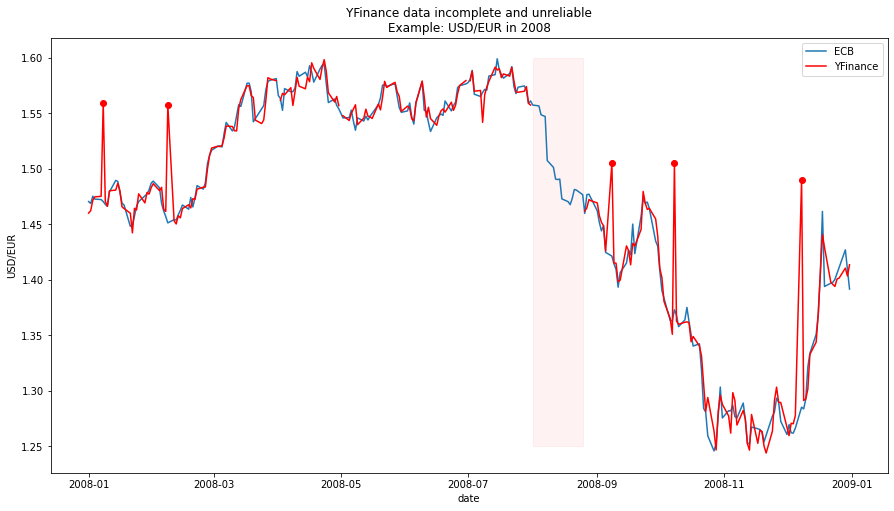

In [27]:
# Create comparison plot of Yfinance and ECB data
plt.figure(figsize=(15, 8))
ax = plt.plot(dev[(dev.index >= datetime(2008, 1, 1)) & (dev.index < datetime(2009, 1, 1))]["USD"], label="ECB")
plt.plot(yfinance_data[(yfinance_data.index >= datetime(2008, 1, 1)) & (yfinance_data.index < datetime(2009, 1, 1))]["USD"], label="YFinance", color="r")
plt.title("YFinance data incomplete and unreliable\nExample: USD/EUR in 2008")
plt.xlabel("date")
plt.ylabel("USD/EUR")
plt.legend()

scatter_data = yfinance_data.loc[(yfinance_data["USD"] - dev["USD"]) > .05]
plt.scatter(scatter_data.index, scatter_data["USD"], color="r", marker="o")

# Create a Rectangle patch
rect = pp.Rectangle((datetime(2008, 8, 1), 1.25),
                    timedelta(days=24), 
                    .35, 
                    linewidth=1, 
                    edgecolor="r", 
                    facecolor="r", 
                    alpha=.05)

# Add the patch to the Axes
plt.gca().add_patch(rect)

plt.savefig("Output/yfinance-data-incomplete.png")